In [1]:
import sys
import subprocess

print("Python executable:", sys.executable)

subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "pip"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "openpyxl"])
#!"{sys.executable}" -m pip list

Python executable: j:\dev\LLMchatbot_MIE2024\.venv\Scripts\python.exe


0

In [2]:

import pandas as pd
import openai
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from openai import OpenAI

client = OpenAI(
    base_url="http://localhost:8000/v1",
    #api_key="dummy-key" - wird nicht gebraucht weil vllm nicht mit internet verbunden ist
)

print(openai.__version__)
print(robjects.r("R.version.string"))

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


2.13.0
[1] "R version 4.5.2 (2025-10-31 ucrt)"



In [3]:
import rpy2.robjects as robjects

robjects.r('''
dir.create(Sys.getenv("R_LIBS_USER"), recursive = TRUE, showWarnings = FALSE)
.libPaths(c(Sys.getenv("R_LIBS_USER"), .libPaths()))
install.packages(c("ggplot2", "dplyr"), repos = "https://cloud.r-project.org", lib = Sys.getenv("R_LIBS_USER"))
''')



R callback write-console: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.5/ggplot2_4.0.1.zip'
  
R callback write-console: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.5/dplyr_1.1.4.zip'
  


Paket 'ggplot2' erfolgreich ausgepackt und MD5 Summen abgeglichen
Paket 'dplyr' erfolgreich ausgepackt und MD5 Summen abgeglichen



R callback write-console: <class 'UnicodeDecodeError'> 'utf-8' codec can't decode byte 0xe4 in position 25: invalid continuation byte <traceback object at 0x000002575434C8C0>


In [4]:
robjects.r('library(ggplot2)')
robjects.r('library(dplyr)')


R callback write-console: 
Attache Paket: 'dplyr'

  
R callback write-console: Die folgenden Objekte sind maskiert von 'package:stats':

    filter, lag

  
R callback write-console: Die folgenden Objekte sind maskiert von 'package:base':

    intersect, setdiff, setequal, union

  


In [5]:
df = pd.read_excel("./testdata_MIE.xlsx")
df = df.infer_objects(copy=False)
df.to_csv("./testdata_MIE.csv", index=False)
df.head()

,PatientAccountID,MPINumber,AssessmentID,Source,CollectedDT,Finding,FindingName,FindingDataType,Value,AdditionalInformation
0,NaN,P-5xxxxxxxx,NaN,Stammdaten,Jul xx 20xx xx:xxAM,Geburtsdatum,NaN,9,xx/19xx,NaN
1,NaN,P-5xxxxxxxx,NaN,Stammdaten,Jun xx 20xx xx:xxPM,Geschlecht,NaN,1,männlich,NaN
2,P-8xxxxxxxxx,P-5xxxxxxxx,NaN,Diagnosen,Jun xx 20xx xx:xxAM,Diagnose,NaN,1,N18.0,Terminale Niereninsuffizienz
3,P-8xxxxxxxxx,P-5xxxxxxxx,NaN,Diagnosen,Jun xx 20xx xx:xxPM,Diagnose,NaN,1,G63.2*,Diabetische Polyneuropathie
4,P-8xxxxxxxxx,P-5xxxxxxxx,NaN,Diagnosen,Jun xx 20xx xx:xxPM,Diagnose,NaN,1,H36.0*,Retinopathia diabetica


In [ ]:
import pandas as pd

def query_template(df: pd.DataFrame, query: str):
    messages = [
        {
            "role": "system",
            "content": (
                "You are an R code generator for data analysis.\n"
                "A data frame named df already exists in the R environment.\n\n"

                "STRICT RULES (MANDATORY):\n"
                "- Output ONLY executable R code.\n"
                "- NO explanations, NO comments, NO markdown.\n"
                "- NEVER load data from files.\n"
                "- NEVER modify or overwrite df.\n"
                "- Use ONLY columns that exist in df.\n\n"

                "PACKAGE RULES (MANDATORY):\n"
                "- If using %>%, filter(), group_by(), summarise(), or n_distinct(), you MUST load library(dplyr).\n"
                "- If creating any plot, you MUST load library(ggplot2).\n\n"

                "DATASET SEMANTICS:\n"
                "- The dataset is event-based: each patient has multiple rows.\n"
                "- Patients are identified by the column MPINumber.\n"
                "- Diagnoses are rows where Finding == 'Diagnose'.\n"
                "- Diagnosis codes are stored in the Value column.\n"
                "- Patient counts MUST use n_distinct(MPINumber).\n\n"

                "BOX PLOT RULES (CRITICAL):\n"
                "- A box plot MUST visualize a distribution of multiple values.\n"
                "- NEVER map MPINumber to the x-axis in a box plot.\n"
                "- For box plots over patients, you MUST:\n"
                "  1) group by MPINumber\n"
                "  2) compute a per-patient count using summarise()\n"
                "  3) create the box plot using ONLY aes(y = <distribution>)\n"
                "- Using aes(x = MPINumber, ...) for box plots is FORBIDDEN.\n\n"

                "PLOT OUTPUT RULES (MANDATORY):\n"
                "- Every plot MUST be saved using ggsave().\n"
                "- Use the filename: diagnoses_boxplot.png\n"
                "- Do NOT rely on print() to render plots.\n"
            )
        },

        # Few-shot example (R)
        {
            "role": "user",
            "content": "How many patients got diagnosed with N18?"
        },
        {
            "role": "assistant",
            "content": (
                "library(dplyr)\n"
                "result <- df %>%\n"
                "  filter(Finding == 'Diagnose', grepl('N18', Value)) %>%\n"
                "  summarise(n_patients = n_distinct(MPINumber))\n"
                "print(result)"
            )
        },

        # Real task
        {
            "role": "user",
            "content": query
        }
    ]

    return messages


def ask_llm(df: pd.DataFrame, query: str) -> str:
    messages = query_template(df, query)

    response = client.chat.completions.create(
        model="qwen",
        messages=messages,
        temperature=0.0,
        max_tokens=400,
    )

    return response.choices[0].message.content


## R - A
Create a box plot showing the distribution of the number of diagnoses per patient.

In [19]:
query = "Create a box plot showing the distribution of the number of diagnoses per patient."
response_text = ask_llm(df, query)


print("R code:")
print(response_text)


R code:
library(ggplot2)
diagnoses_distribution <- df %>%
  filter(Finding == 'Diagnose') %>%
  group_by(MPINumber) %>%
  summarise(num_diagnoses = n_distinct(Value))

ggplot(diagnoses_distribution, aes(y = num_diagnoses)) +
  geom_boxplot() +
  labs(title = "Distribution of Number of Diagnoses per Patient",
       y = "Number of Diagnoses",
       x = "Patient ID") +
  theme_minimal()

ggsave("diagnoses_boxplot.png")


In [20]:
import rpy2.robjects as robjects
from rpy2.robjects import conversion, pandas2ri

with conversion.localconverter(
    robjects.default_converter + pandas2ri.converter
):
    robjects.globalenv["df"] = df


j:\dev\LLMchatbot_MIE2024\.venv\Lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "PatientAccountID". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '
j:\dev\LLMchatbot_MIE2024\.venv\Lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "AdditionalInformation". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '


In [21]:
robjects.r(response_text)

Saving 6.92 x 6.92 in image


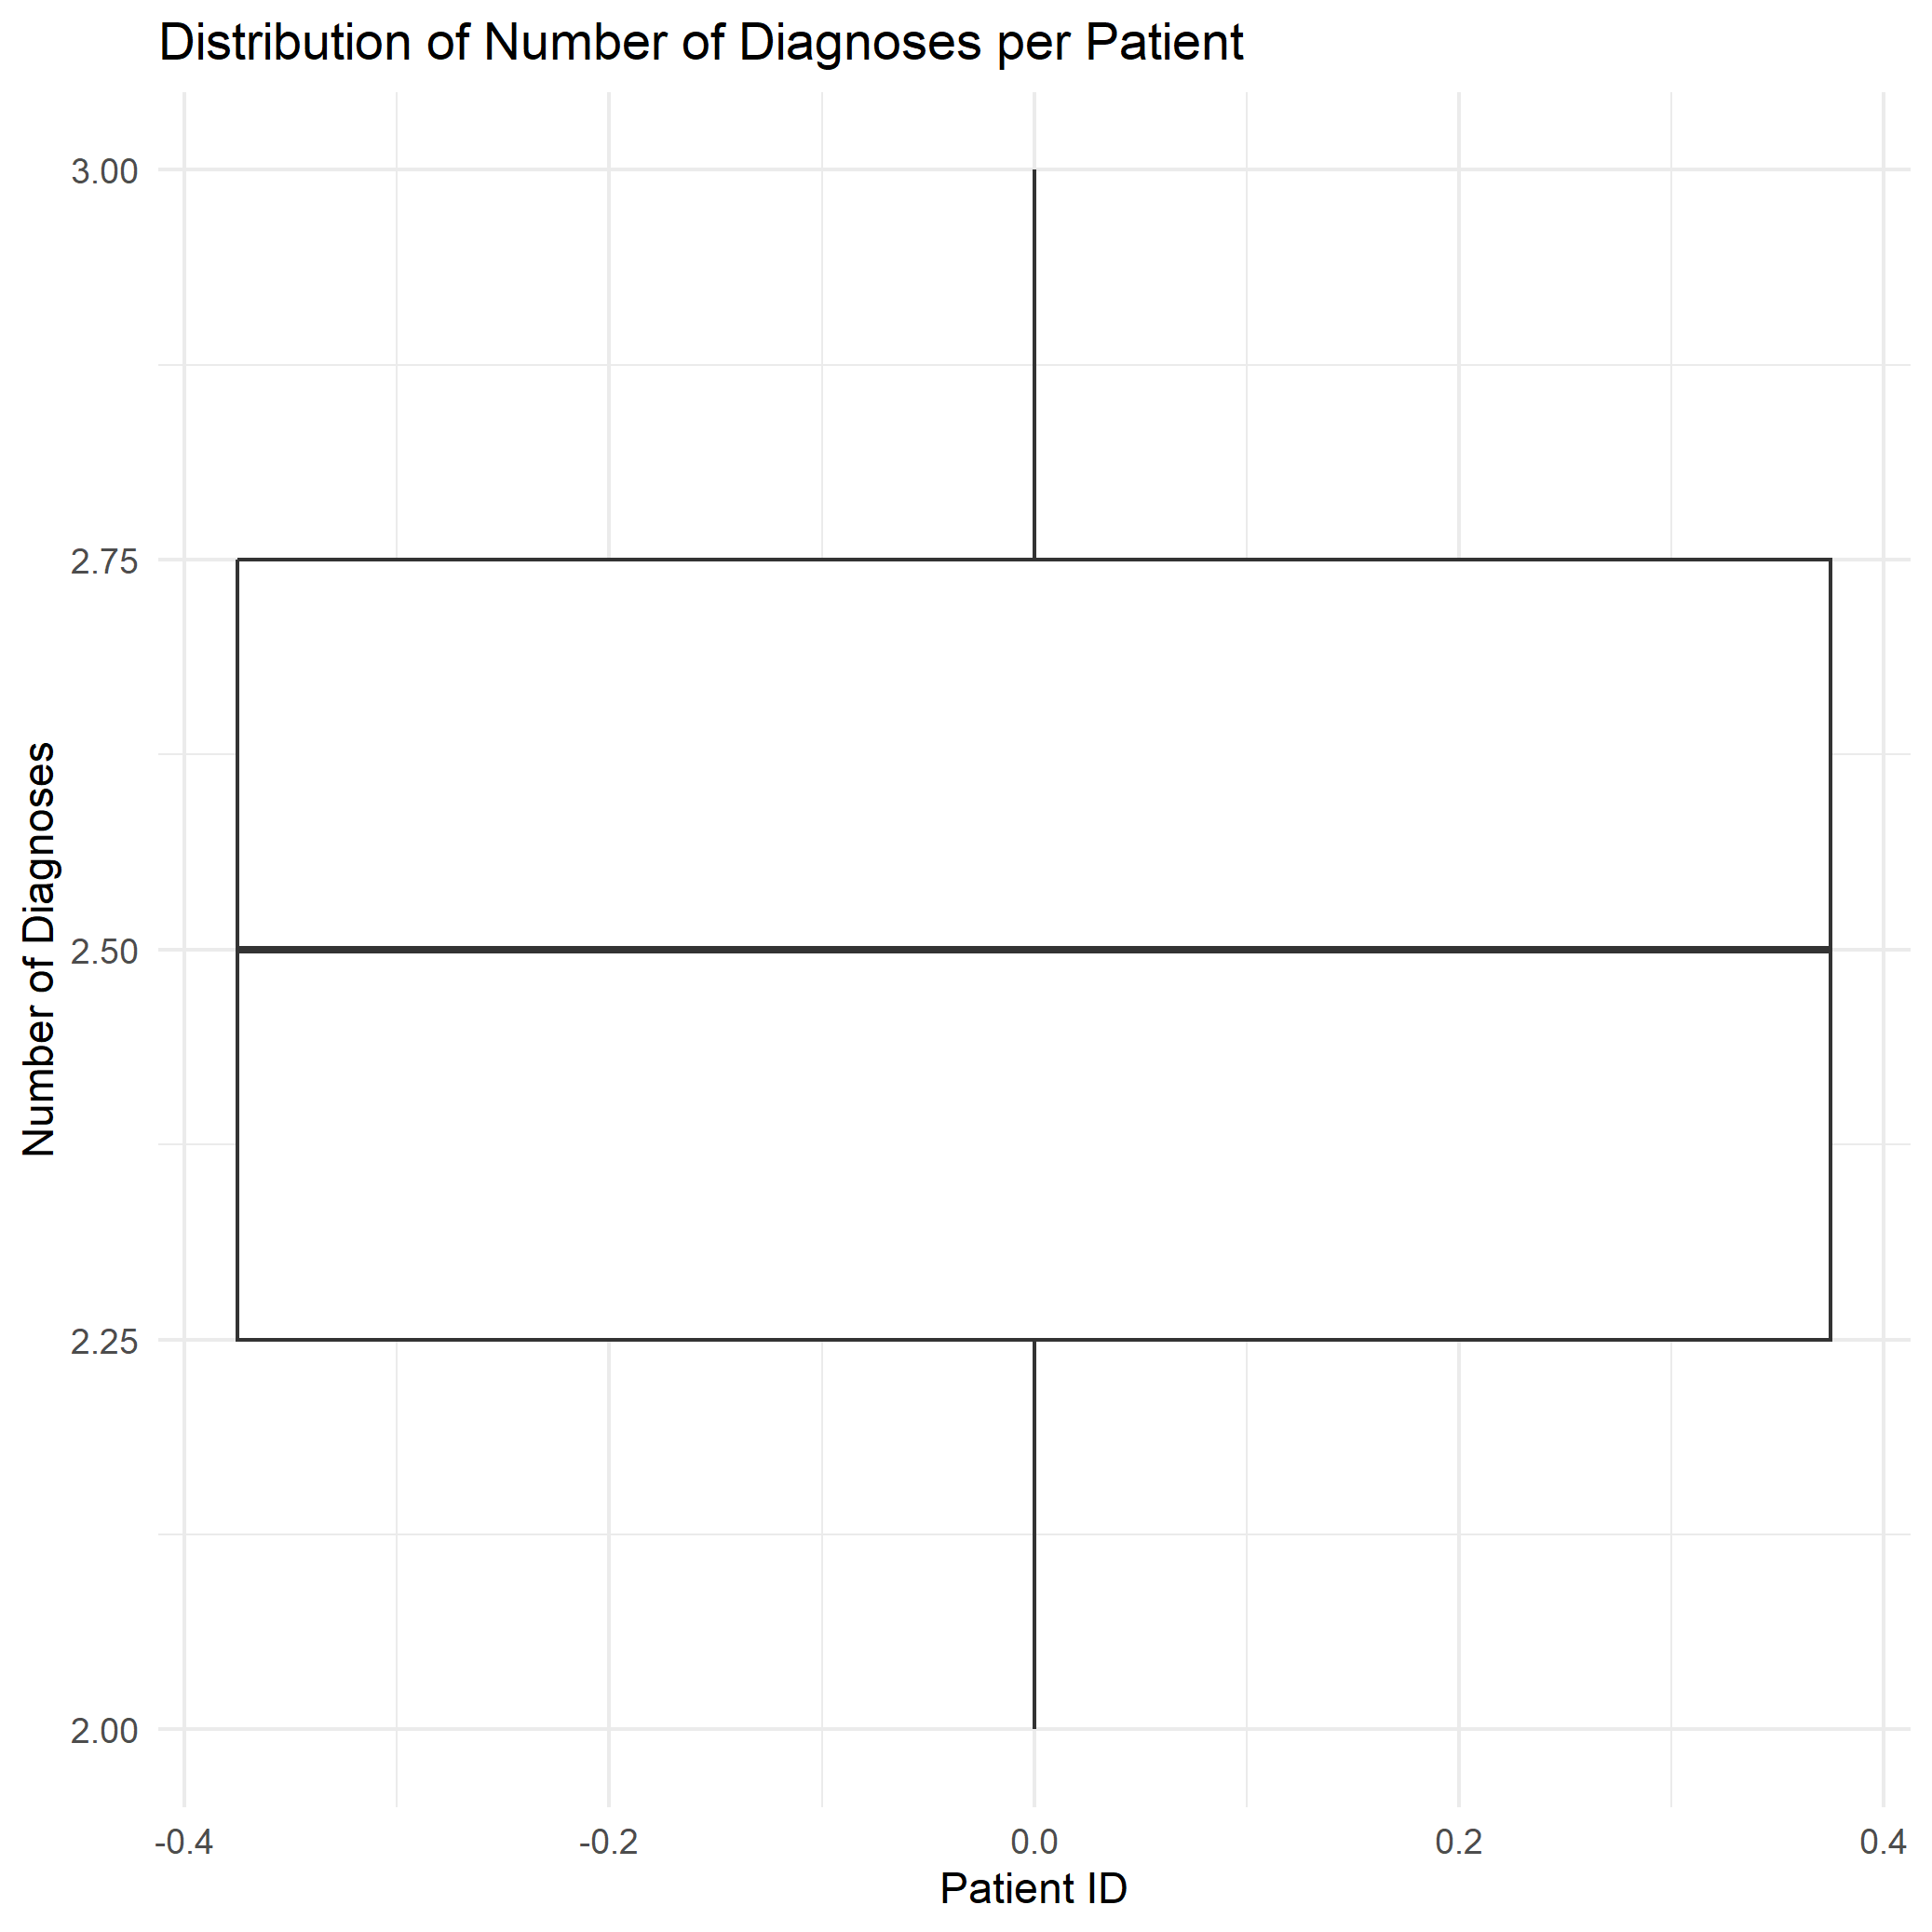

: 

In [ ]:
from IPython.display import Image, display

display(Image(filename="R_PICS/diagnoses_boxplot.png"))